In [1]:
%matplotlib notebook

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numpy import std, pad, amax, abs
from numpy.random import normal
from numpy.fft import fftshift, ifftshift, fft2, ifft2 
from google.colab.patches import cv2_imshow

In [3]:
# Filenames
filename = '/content/lenna.jpg'
test_filenames = ['./pics/barraxx.bmp', './pics/BDBOB.jpg',
                  './pics/pru2old.bmp']

# Show original image

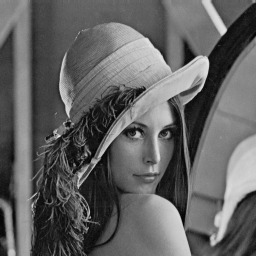

In [4]:
original = cv.imread(filename=filename, flags=cv.IMREAD_COLOR)
cv2_imshow(original)

# Blur + Noise

In [5]:
def noisy_gauss(image, snr=20):
      row, col, ch = image.shape
      sigma_image = std(image)
      sigma_noise = np.sqrt(sigma_image**2 * 10**(-snr/10))
      noise = normal(loc=0.0, scale=sigma_noise, size=image.shape)
      noisy = image + noise
      noisy = np.where(noisy < 0,  0, noisy)
      noisy = np.where(noisy > 255, 255, noisy)
      noisy = noisy.astype(dtype=np.uint8)
      return noisy, sigma_noise

In [6]:
kernel_shape = (5, 5)
lenna_blur = cv.blur(src=original, ksize=(5, 5))
lenna_blur_noise, noise_sigma = noisy_gauss(image=lenna_blur, snr=10)

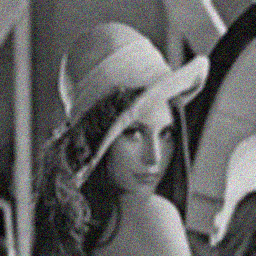

In [7]:
cv2_imshow(lenna_blur_noise)

# Wiener

In [8]:
kernel = 1 / kernel_shape[0] / kernel_shape[1]
kernel *= np.ones(shape=kernel_shape)

In [9]:
a, b, _ = original.shape
padded_kernel = np.zeros(shape=(a, b))
c, d = kernel.shape
padded_kernel[a//2 - c//2:a//2 + c//2 +1, b//2 - d//2: b//2 + d//2 +1] = kernel
# kernel fft2.
centered_fft2_kernel = fftshift(fft2(fftshift(padded_kernel)))
centered_fft2_kernel += 1.2

In [10]:
def recover(img, h, sf=None, sn=None, wiener_inverse=False):

  channels = []
  for channel in cv.split(img):
    channel = fftshift(fft2(channel))

    if wiener_inverse:
      clean_lena = channel / h * np.abs(h)**2 / (np.abs(h)**2 + sn / sf)
    else:
      clean_lena = channel / h

    # filtered image ifft2 and normalize to unity
    clean_lena = np.abs(ifft2(ifftshift(clean_lena)))
    maximum = amax(clean_lena)
    clean_lena /= maximum
    clean_lena *= 255
    clean_lena = clean_lena.astype(np.uint8)
    channels.append(clean_lena)

  clean_lena = cv.merge(channels)
  newww = np.hstack((clean_lena, lenna_blur_noise))
  cv2_imshow(newww)
  return clean_lena

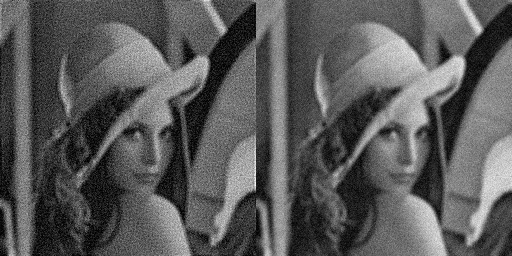

In [11]:
lenna_blur_noise = cv.cvtColor(lenna_blur_noise, cv.COLOR_BGR2GRAY)

noise = np.ones(shape=lenna_blur_noise.shape) * noise_sigma**2

sf = fftshift(fft2(lenna_blur_noise))
wiener_result = recover(img=lenna_blur_noise, h=centered_fft2_kernel, sf=sf, sn=noise, wiener_inverse=True)

# Inverse Filtering

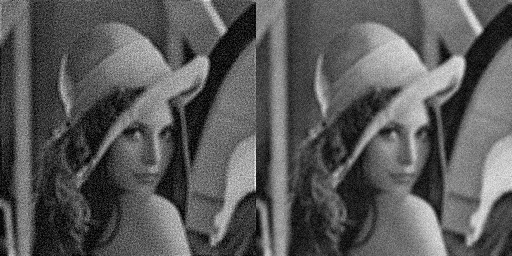

In [12]:
inverse_result = recover(img=lenna_blur_noise, h=centered_fft2_kernel, wiener_inverse=False)

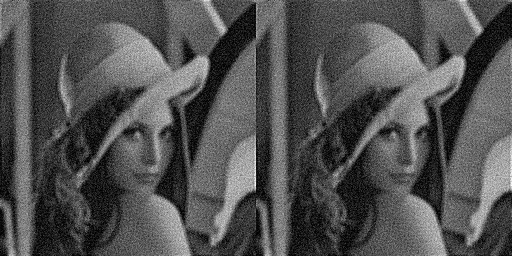

Wiener vs Inverse


In [13]:
stacked = np.hstack((wiener_result, inverse_result))
cv2_imshow(stacked)
print('Wiener vs Inverse')